### check phase precession of a hd cell in the model

In [1]:
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
from network import HD_cell
from scipy.ndimage import gaussian_filter

import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from scipy.stats import mannwhitneyu

%matplotlib inline

bm.set_platform('cpu')
# simulation time step
bm.set_dt(1.)

/home/zilong/anaconda3/envs/HDPhasePrecession/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
def get_HDtuningMap(activity, directions, cellindex_x, 
                 filter=False, samples_per_sec=10, dim=100):
    '''
    Get the tuning map of a cell
    Input:
        activity: the activity of the network across time
        directions: the HD direction of the animal (ranging from -np.pi to np.pi)
        cellindex: the index of the cell
        firing_rate_thres: the threshold of the firing rate
    '''
    
    activity_4_cell_i = activity[:, cellindex_x]
    
    #direction in bins
    direction_x = ((directions+np.pi)/(2*np.pi)*dim).astype(int).flatten()
    
    #Calculate the summarized  activity and the occupancy time in each direction bin 
    Time_In_Direction = np.zeros(dim)
    FR_In_Direction = np.zeros(dim)

    diffTimeStamps = np.asarray([1/samples_per_sec]*len(directions))
    
    np.add.at(Time_In_Direction, direction_x, diffTimeStamps)
    np.add.at(FR_In_Direction, direction_x, activity_4_cell_i)
    
    map = np.divide(FR_In_Direction, Time_In_Direction, out=np.zeros_like(FR_In_Direction), where=Time_In_Direction!=0)
    
    if filter is True:
        #Gaussian smoothing the map (This may not work. Need to change to 1D case later...)
        map = gaussian_filter(map, sigma=2)

    return map


def plot_populationsweep(ax, t, Head_direction, bump_activity):
    
    labelsize=10
    ticksize=8
    # imshow and smooth
    ax.imshow(bump_activity.T*100, aspect='auto', extent=[t[0], t[-1], -bm.pi, bm.pi], cmap='inferno', origin='lower')
    
    #plot the head direction as a line
    # ax.plot(t, Head_direction, color='white', lw=0.5)
    
    #instead of plot, use pair line to plot the head direction, if the head direction is not continuous, then do not plot
    for i in range(len(Head_direction)-1):
        if np.abs(Head_direction[i+1]-Head_direction[i])<np.pi:
            ax.plot([t[i], t[i+1]], [Head_direction[i], Head_direction[i+1]], color='lightgrey', lw=0.2)
    
    #add colorbar
    cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('Activity (Hz)', fontsize=ticksize)
    #set ticks
    cbar.ax.set_yticks([0, int(np.max(bump_activity)*100/10)*10])

    cbar.ax.tick_params(labelsize=ticksize)
    
    #xticks
    ax.set_xticks([t[0], t[-1]])
    ax.set_xticklabels([t[0]-t[0], np.round((t[-1]-t[0])/1000,1)])
    #yticks
    ax.set_yticks([-bm.pi, 0, bm.pi])
    ax.set_yticklabels([r'$0\degree$', r'$180\degree$', r'$360\degree$'])
    
    #label
    ax.set_xlabel('Time (s)', fontsize=labelsize)
    ax.set_ylabel('Direction', fontsize=labelsize)
    #ticksize
    ax.tick_params(axis='both', which='major', labelsize=ticksize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax


def plot_HD_tuningMap(ax, tuningmap):
    '''
    Polar plot of the tuning map
    '''
    
    labelsize=10
    ticksize=8
    
    num_hd = len(tuningmap)
    ax.plot(np.linspace(0, 2*np.pi, num_hd), tuningmap, color='#6EC7D6', linewidth=2)
    #get the peak direction of the tuning map on np.linspace(0, 2*np.pi, num_hd)
    peak_direction = np.linspace(0, 2*np.pi, num_hd)[np.argmax(tuningmap)]
    #add as title in degrees as HD_{peak} = peak_direction*180/pi
    # ax.set_title(r'$HD_{peak} = %d\degree$' % (peak_direction*180/np.pi), fontsize=labelsize)


    # Set xticks as 0, 90, 180, 270
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    ax.set_xticklabels([r'$0\degree$', r'$90\degree$', r'$180\degree$', r'$270\degree$'], fontsize=ticksize-2)
    #moving xticks closer to the plot
    ax.tick_params(axis='x', pad=-5)
    # Hide the y-ticks but keep the grid
    #5 yticks
    ax.set_yticks(np.linspace(0, np.max(tuningmap), 5))
    ax.yaxis.set_tick_params(size=0)  # Set tick size to 0 to hide y-ticks
    ax.set_yticklabels([])
    
    return ax

In [3]:
def circular_gaussian(x, a, x0, sigma, b):
    """Circular Gaussian function."""
    return a * np.exp(-((x - x0 + np.pi) % (2 * np.pi) - np.pi)**2 / (2 * sigma**2)) + b

def fit_circular_gaussian(tuning_map, x):
    """Fit a circular Gaussian to the tuning map."""
    initial_guess = [np.max(tuning_map), np.argmax(tuning_map) * (2 * np.pi / len(tuning_map)), 1, np.min(tuning_map)]  # Initial guesses for a, x0, sigma, b
    popt, _ = curve_fit(circular_gaussian, x, tuning_map, p0=initial_guess, bounds=(0, np.inf))
    return popt

def compute_gaussian_width(tuning_map):
    """Compute the width of the Gaussian bump on a circular vector."""
    x = np.linspace(0, 2 * np.pi, len(tuning_map), endpoint=False)
    popt = fit_circular_gaussian(tuning_map, x)
    sigma = popt[2]
    width = 4 * sigma
    return width, popt

def generate_traj_hd(x0, v, T, var=1):
    x = []
    xt = x0
    for i in range(T):
        xt = xt + v * (1 + var*np.random.randn(1)) * bm.dt
        if xt > np.pi:
            xt -= 2 * np.pi
        if xt < -np.pi:
            xt += 2 * np.pi
        x.append(xt)
    return np.array(x)

# Function to apply circular smoothing
def circular_smoothing(angles, sigma):
    """
    Apply Gaussian smoothing to a 1D array of angular data.
    
    Parameters:
    angles (1D array): Array of angles in radians or degrees (but consistent)
    sigma (float): The standard deviation for Gaussian kernel.
    
    Returns:
    smoothed_angles (1D array): Smoothed angular data.
    """
    
    # Convert to Cartesian coordinates
    sin_vals = np.sin(angles)
    cos_vals = np.cos(angles)
    
    # Apply Gaussian smoothing to sine and cosine components
    smoothed_sin = gaussian_filter(sin_vals, sigma=sigma, mode='wrap')
    smoothed_cos = gaussian_filter(cos_vals, sigma=sigma, mode='wrap')
    
    # Recompute the angle from the smoothed sine and cosine
    smoothed_angles_rad = np.arctan2(smoothed_sin, smoothed_cos)

    
    return smoothed_angles_rad






In [16]:
def simulate(angular_velocity_gain=1, offset=-0.08, theta_mod_base=0.1, var=1, N_cycles=40):
    
    '''
    0.5, 15, 1: precession HD
    0., 0,, 1: normal HD (no theta tuned)
    3.5, 0, 1: theta tuned no precession 
    '''

    # run network
    
    HD_net = HD_cell(num=100, 
                    noise_stre=0.6, 
                    tau=10., tau_v=100., 
                    k=1., mbar=10, a=0.4, A=3., J0=4., 
                    z_min=-bm.pi, z_max=bm.pi)

    def run_HDNet(i, Head_direction):  # 20 x size

        T_theta = 100 #ms
        t = i*bm.dt
        theta_phase = bm.mod(t, T_theta)/T_theta
        #calculate TheataModulator at time step i
        ThetaModulator_HD = 1+(theta_mod_base+0.1*angular_velocity_gain)*bm.cos(theta_phase*2*bm.pi)
        #ThetaModulator_HD = 1+0*bm.cos(theta_phase*2*bm.pi)
        HD_net.step_run(i, Head_direction, ThetaModulator_HD)
        Internal_direction = HD_net.center
        bump_activity = HD_net.r
        return Internal_direction, bump_activity, theta_phase    
    
    
    angular_velocity = angular_velocity_gain*np.pi/(1e3)
    
    if angular_velocity_gain ==0:
        numT = 4000
        x0 = offset*np.pi
        start = int(3*numT/4)
        end = numT
    else:
        N = N_cycles
        numT = int(N*2*np.pi/(bm.dt*angular_velocity))
        x0 = -np.pi
        onecycleT = numT/(N)
        start = int(0.*onecycleT)
        end = int(onecycleT)        
    time_steps = np.arange(numT)

    Head_direction = generate_traj_hd(x0=x0, v=angular_velocity, T=numT, var=var)
    
    #apply circular smoothing to the head direction
    Head_direction = circular_smoothing(Head_direction, sigma=10)

    
    center_HD, HD_activity, theta_phase = bm.for_loop(
        run_HDNet, (time_steps, Head_direction), progress_bar=True
    )

    theta_phase = theta_phase*2*np.pi
    max_bump_activity = np.max(HD_activity, axis=1)
    
    return start, end, time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase




100%|██████████| 80000/80000 [00:00<00:00, 107166.23it/s]


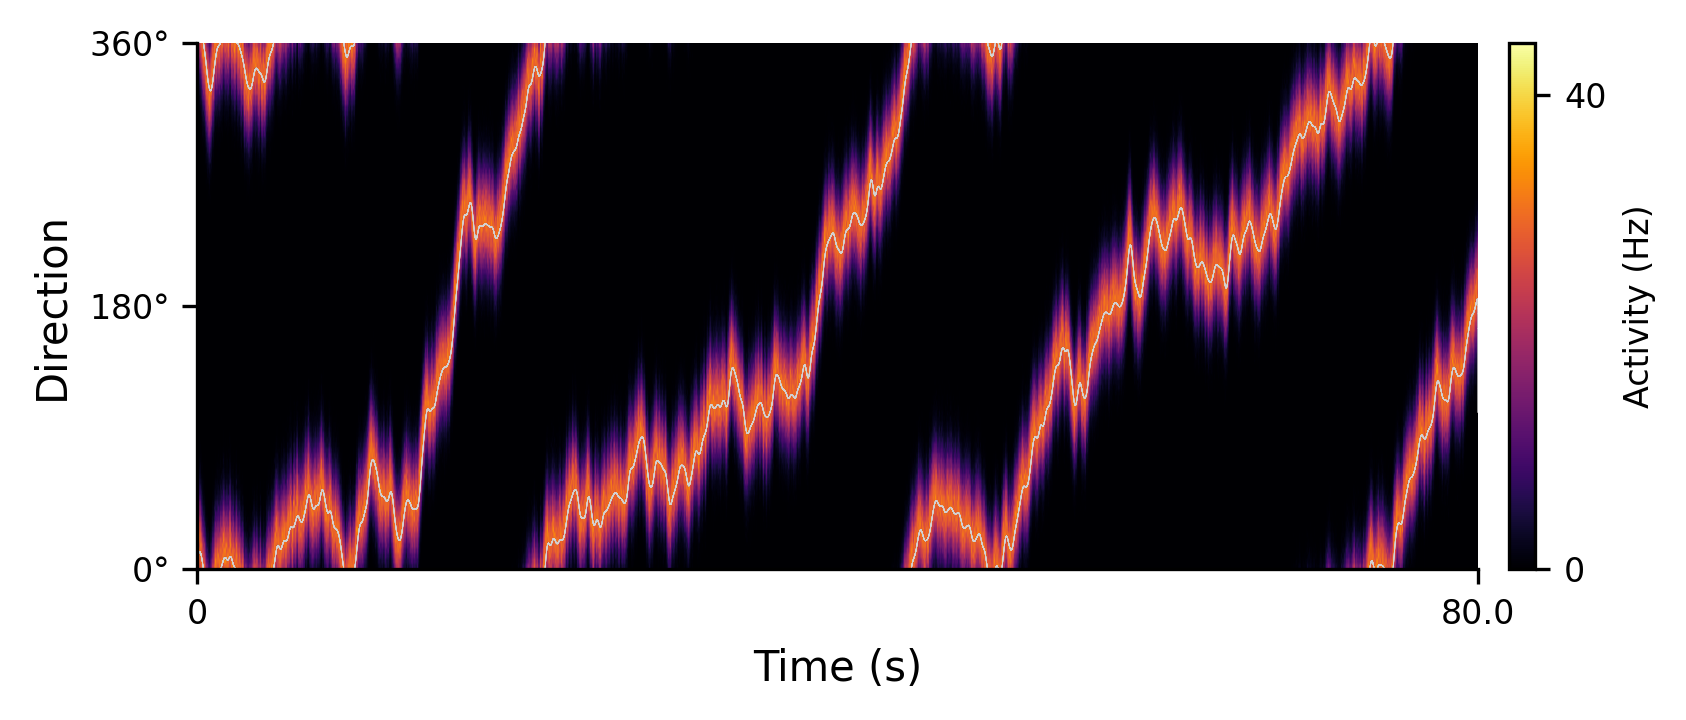

In [25]:
fig = plt.figure(figsize=(6, 2.5), dpi=300)

gs = gridspec.GridSpec(1, 1)

labelsize = 10
ticksize = 8
s_size = 1

np.random.seed(0)

results = simulate(angular_velocity_gain=0.1, offset=-0.08, theta_mod_base=0.2, var=50, N_cycles=4)
start, end, time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase = results

ax = fig.add_subplot(gs[0, 0])
ax = plot_populationsweep(ax, time_steps[start:5*end], Head_direction[start:5*end], HD_activity[start:5*end])

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/population_activity.pdf', dpi=300)

100%|██████████| 80000/80000 [00:00<00:00, 105745.00it/s]


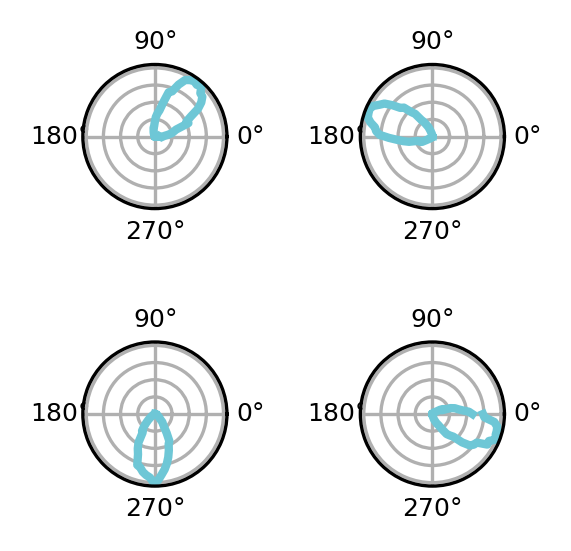

In [23]:
fig = plt.figure(figsize=(2, 2), dpi=300)

gs = gridspec.GridSpec(2, 2)

labelsize = 10
ticksize = 8
s_size = 1

results = simulate(angular_velocity_gain=1, offset=-0.08, theta_mod_base=0.2, var=50, N_cycles=40)
start, end, time_steps, Head_direction, center_HD, max_bump_activity, HD_activity, theta_phase = results

#plot HD tuning map
ax = fig.add_subplot(gs[0], polar=True)
cellindex = 15; num_hd = 100
tuningmap = get_HDtuningMap(HD_activity, Head_direction, cellindex, filter=False, samples_per_sec=1, dim=num_hd)
#find the width of the tuning map
width, _ = compute_gaussian_width(tuningmap)
#rad to degree
width = width*180/np.pi
ax = plot_HD_tuningMap(ax, tuningmap)
# ax.set_title(f'tuning width: {width:.1f} °', fontsize=ticksize)

ax = fig.add_subplot(gs[1], polar=True)
cellindex = 45; num_hd = 100
tuningmap = get_HDtuningMap(HD_activity, Head_direction, cellindex, filter=False, samples_per_sec=1, dim=num_hd)
#find the width of the tuning map
width, _ = compute_gaussian_width(tuningmap)
#rad to degree
width = width*180/np.pi
ax = plot_HD_tuningMap(ax, tuningmap)
# ax.set_title(f'tuning width: {width:.1f} °', fontsize=ticksize)

ax = fig.add_subplot(gs[2], polar=True)
cellindex = 75; num_hd = 100
tuningmap = get_HDtuningMap(HD_activity, Head_direction, cellindex, filter=False, samples_per_sec=1, dim=num_hd)
#find the width of the tuning map
width, _ = compute_gaussian_width(tuningmap)
#rad to degree
width = width*180/np.pi
ax = plot_HD_tuningMap(ax, tuningmap)
# ax.set_title(f'tuning width: {width:.1f} °', fontsize=ticksize)

ax = fig.add_subplot(gs[3], polar=True)
cellindex = 95; num_hd = 100
tuningmap = get_HDtuningMap(HD_activity, Head_direction, cellindex, filter=False, samples_per_sec=1, dim=num_hd)
#find the width of the tuning map
width, _ = compute_gaussian_width(tuningmap)
#rad to degree
width = width*180/np.pi
ax = plot_HD_tuningMap(ax, tuningmap)
# ax.set_title(f'tuning width: {width:.1f} °', fontsize=ticksize)

plt.tight_layout()


plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/HD_tuning_maps.pdf', dpi=300)